In [161]:
from pathlib import Path
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import Functional_Fusion.util as util
import itertools
from scipy import stats
import os
import pingouin as pg
from copy import deepcopy
from paths import set_base_dir


base_dir = set_base_dir()


In [162]:
# import fissure data
distance = pd.read_csv(f'../data/fissures.csv', sep='\t')

# import demographic data
info = pd.read_csv(
    f'{base_dir}/participants.tsv', sep='\t')

# import list of subjects that are included in the template
template_sample = pd.read_csv(
    f'{base_dir}/../code/cerebellar_degeneration/data/template_DeCon_subjects.tsv', sep=',')
included_subject_list = template_sample.subject.tolist()


In [163]:
data = pd.merge(distance, info, left_on='subject',
                right_on='participant_id', how='inner').drop(columns=['participant_id'])

# add information on whether subject was included in the template to the fissure data
included = [subject in included_subject_list for subject in data.subject.tolist()]
data['included'] = included

# add information on whether subject was included in the template to the participant demographics
info['included'] = [subject in included_subject_list for subject in info.participant_id.tolist()]
# add information on which scan (pre or post) was used for the template
info['timepoint'] = None
for s,subject in enumerate(info.participant_id):
    if subject in included_subject_list:
        info.at[s,'timepoint'] = template_sample[template_sample.subject == subject].session.values[0].split('-')[1]


## Demographics: Template generation and validation sample

In [164]:
# Show demographics of included and excluded subjects (count categorical values of sex, group and condition and calculate mean and std of age)
demographics = info.groupby(['included']).agg({'sex': pd.Series.value_counts,
                                               'age': ['mean', 'std'],
                                               'group': pd.Series.value_counts,
                                               'condition': pd.Series.value_counts,
                                               'timepoint': pd.Series.value_counts})
demographics = demographics.reindex([True, False])
demographics.to_latex(f'{base_dir}/../code/cerebellar_degeneration/latex_tables/demographics.tex')

sex_levels = info['sex'].unique()
group_levels = info['group'].unique()
condition_levels = info['condition'].unique()
timepoint_levels = info['timepoint'].unique()

print("Sex levels:", sex_levels)
print("Group levels:", group_levels)
print("Condition levels:", condition_levels)
print("Timepoint levels:", timepoint_levels)

demographics



Sex levels: ['m' 'f']
Group levels: ['p' 'c']
Condition levels: ['PropFB' 'VMFB' 'VM' 'Prop']
Timepoint levels: ['pre' None 'post']


sex     age                   group         condition  \
         value_counts    mean        std value_counts      value_counts   
included                                                                  
True         [23, 17]  57.150   9.962880     [20, 20]  [10, 10, 10, 10]   
False        [22, 18]  53.975  11.850538     [20, 20]  [10, 10, 10, 10]   

            timepoint  
         value_counts  
included               
True         [21, 19]  
False              []

In [165]:
# Counterbalancing of group x condition combinations
group_condition = info.groupby(['included','group', 'condition']).size().unstack(fill_value=0)
print(group_condition)
# Counterbalancing of group x timepoint combinations
group_timepoint = info.groupby(['included','group', 'timepoint']).size().unstack(fill_value=0)
print(group_timepoint)
# Counterbalancing of condition x timepoint combinations
condition_timepoint = info.groupby(['included','condition', 'timepoint']).size().unstack(fill_value=0)
print(condition_timepoint)



condition       Prop  PropFB  VM  VMFB
included group                        
False    c         6       5   7     2
         p         4       5   3     8
True     c         4       5   3     8
         p         6       5   7     2
timepoint       post  pre
included group           
True     c        11    9
         p        10   10
timepoint           post  pre
included condition           
True     Prop          5    5
         PropFB        6    4
         VM            5    5
         VMFB          5    5


## Fissure Distance

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_64938/685659252.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="space", y="distances", errorbar="se", order=[


<Axes: xlabel='space', ylabel='distances'>

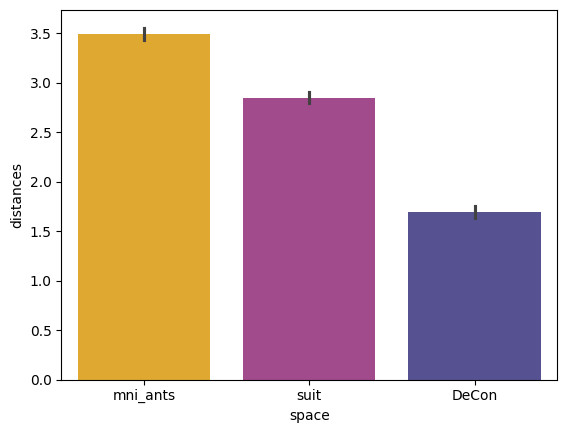

In [166]:
x = data.query('space == "DeCon"').distances
y = data.query('space == "mni_ants"').distances
stats.ttest_rel(x, y)


# make colours out of hex codes
hex_codes = ['#FCB414', '#AF3B94', '#4D489C']
# convert hex to matplotlib format
custom_palette = sns.color_palette(hex_codes)


sns.barplot(data=data, x="space", y="distances", errorbar="se", order=[
            'mni_ants', 'suit', 'DeCon'], palette=custom_palette)



In [167]:
# Make a summary table of the mean (not the std) fissure distances with the columns DeCon, MNI and SUIT and the rows included and excluded and each row have sub-rows of fissure 1 cerebellar_mask, fissure 1 vermal and fissure 2 cerebellar_mask
summary_mean = data.groupby(['included', 'space', 'fissure', 'mask']).agg({'distances': ['mean']})
summary_mean = summary_mean.unstack(level=1)
# Round all values to the second decimal
summary_mean = summary_mean.round(2)

summary_mean.to_latex(f'{base_dir}/../code/cerebellar_degeneration/latex_tables/fissure_summary.tex')


# Summarize standard deviation
summary_std = data.groupby(['included', 'space', 'fissure', 'mask']).agg({'distances': ['std']})
summary_std = summary_std.unstack(level=1)
# Round all values to the second decimal
summary_std = summary_std.round(2)

summary_std.to_latex(f'{base_dir}/../code/cerebellar_degeneration/latex_tables/fissure_summary_std.tex')

summary_mean

distances               
                                      mean               
space                                DeCon mni_ants  suit
included fissure mask                                    
False    1       cerebellar_mask      2.26     3.80  3.24
                 vermal               0.96     3.22  2.40
         2       cerebellar_mask      1.83     3.22  2.71
True     1       cerebellar_mask      2.25     4.04  3.41
                 vermal               0.81     3.16  2.37
         2       cerebellar_mask      2.06     3.51  2.97

## Test differences in fissure distance for validation sample (train and test subjects)

### Overall distance (both fissures, whole cerebellum) in all 80 participants


In [168]:

suit = data.query(
    'space == "suit" & mask == "cerebellar_mask"').distances
degen = data.query(
    'space == "DeCon" & mask == "cerebellar_mask"').distances
mni = data.query(
    'space == "mni_ants" & mask == "cerebellar_mask"').distances
reduction = (suit.mean()-degen.mean())/suit.mean()
print(f'Overall reduction in cerebellar fissures to MNI: {round(reduction*100,2)}% (from {round(mni.mean(),2)} to {round(degen.mean(),2)})')
print(f'Overall reduction in cerebellar fissures to SUIT: {round(reduction*100,2)}% (from {round(suit.mean(),2)} to {round(degen.mean(),2)})')

# result = stats.ttest_rel(degen, mni)
# df = len(degen) - 1
# print(f'\t(t({df})={round(result.statistic,2)}, p={result.pvalue:.2e})\n')

# result = stats.ttest_rel(degen, suit)
# df = len(degen) - 1
# print(f'\t(t({df})={round(result.statistic,2)}, p={result.pvalue:.2e})\n')

Overall reduction in cerebellar fissures to MNI: 31.79% (from 3.64 to 2.1)
Overall reduction in cerebellar fissures to SUIT: 31.79% (from 3.08 to 2.1)


### Fissure 1

In [169]:
fissure=1
for included in [True, False]:
    for mask in ['vermal', 'cerebellar_mask']:
        # Test against MNI
        x = data.query(
            'space == "DeCon" & included == @included & fissure == @fissure & mask == @mask').distances
        y = data.query(
            'space == "mni_ants" & included == @included & fissure == @fissure & mask == @mask').distances
        t,p = stats.ttest_rel(x, y)
        print(
            f'Fissure: {fissure} \nSample: {"Validation" if included else "Training"}\nMask: {mask}\n\tDifference degeneration vs mni: t = {round(t,3)}, p = {round(p,4)}')
        # Test against SUIT
        y = data.query(
            'space == "suit" & included == @included & fissure == @fissure & mask == @mask').distances
        print(
            f'\tDifference degeneration vs suit: t = {round(t,3)}, p = {p}')
        

Fissure: 1 
Sample: Validation
Mask: vermal
	Difference degeneration vs mni: t = -15.49, p = 0.0
	Difference degeneration vs suit: t = -15.49, p = 2.974188863270597e-18
Fissure: 1 
Sample: Validation
Mask: cerebellar_mask
	Difference degeneration vs mni: t = -14.912, p = 0.0
	Difference degeneration vs suit: t = -14.912, p = 1.0626638592852354e-17
Fissure: 1 
Sample: Training
Mask: vermal
	Difference degeneration vs mni: t = -12.904, p = 0.0
	Difference degeneration vs suit: t = -12.904, p = 1.1816185956740551e-15
Fissure: 1 
Sample: Training
Mask: cerebellar_mask
	Difference degeneration vs mni: t = -15.668, p = 0.0
	Difference degeneration vs suit: t = -15.668, p = 2.0211069968265836e-18


([<matplotlib.axis.YTick at 0x15c634d00>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4')])

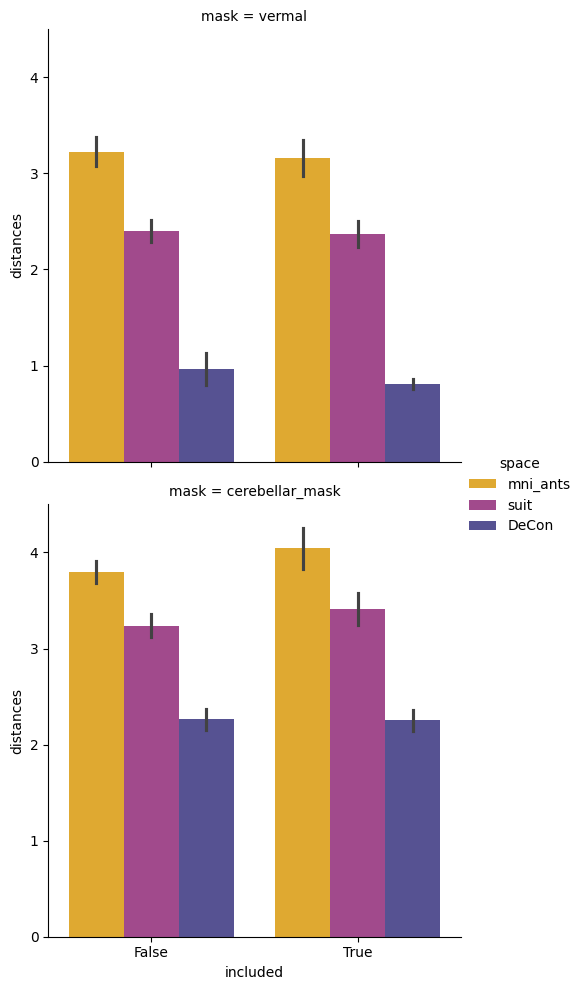

In [170]:
sns.catplot(data=data[data.fissure == 1], x="included", y="distances", row="mask",
            hue="space", kind="bar", errorbar="se", hue_order=['mni_ants', 'suit', 'DeCon'], palette=custom_palette)
plt.ylim(0, 4.5)
plt.yticks(np.arange(0, 5, 1))

### Fissure 2

In [171]:
fissure = 2
for included in [True, False]:
    for mask in ['cerebellar_mask']:
        # Test against MNI
        x = data.query(
            'space == "DeCon" & included == @included & fissure == @fissure & mask == @mask').distances
        y = data.query(
            'space == "mni_ants" & included == @included & fissure == @fissure & mask == @mask').distances
        t, p = stats.ttest_rel(x, y)
        print(
            f'Fissure: {fissure} \nSample: {"Validation" if included else "Training"}\nMask: {mask}\n\tDifference degeneration vs mni: t = {round(t,3)}, p = {round(p,4)}')
        # Test against SUIT
        y = data.query(
            'space == "suit" & included == @included & fissure == @fissure & mask == @mask').distances
        print(
            f'\tDifference degeneration vs suit: t = {round(t,3)}, p = {round(p,4)}')


Fissure: 2 
Sample: Validation
Mask: cerebellar_mask
	Difference degeneration vs mni: t = -13.053, p = 0.0
	Difference degeneration vs suit: t = -13.053, p = 0.0
Fissure: 2 
Sample: Training
Mask: cerebellar_mask
	Difference degeneration vs mni: t = -18.461, p = 0.0
	Difference degeneration vs suit: t = -18.461, p = 0.0


(0.0, 4.5)

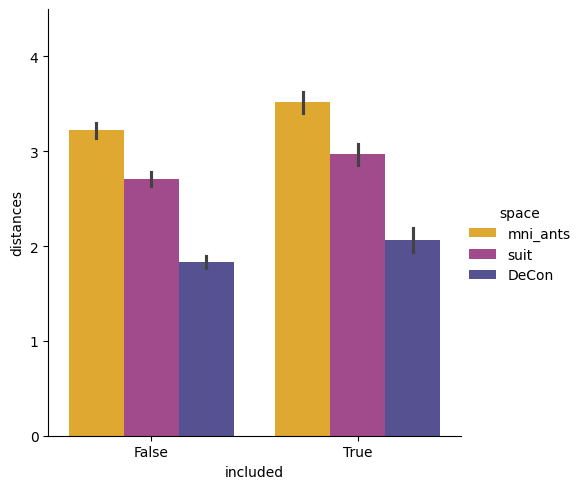

In [172]:
sns.catplot(data=data[data.fissure == 2], x="included", y="distances",
            hue="space", kind="bar", errorbar="se", hue_order=['mni_ants', 'suit', 'DeCon'], palette=custom_palette)
plt.yticks(np.arange(0, 5, 1))
plt.ylim(0, 4.5)


# No patient-control differences in fissure alignment
Ensure that there are no systematic differences in alignment between groups in the new template space (DeCon)

In [173]:
patients = data.query(
        'space =="DeCon" & fissure == 1 & mask == "vermal" & group == "p"').distances
controls = data.query(
    'space == "DeCon" & fissure == 1 & mask == "vermal" & group == "c"').distances
t, p = stats.ttest_ind(patients, controls)
df = len(patients) + len(controls) - 2
print(
    f'Fissure: 1\nMask: Vermal\n\tDifference patient vs control: \n(t({df})={round(t,2)}, p={p:.2f})\n')

for fissure in [1, 2]:
    patients = data.query(
        'space =="DeCon"  & mask == "cerebellar_mask" & fissure == @fissure & group == "p"').distances
    controls = data.query(
        'space == "DeCon"  & mask == "cerebellar_mask" & fissure == @fissure & group == "c"').distances
    t, p = stats.ttest_ind(patients, controls)
    df = len(patients) + len(controls) - 2
    print(
        f'Fissure: {fissure}\n\tDifference patient vs control: \n(t({df})={round(t,2)}, p={p:.2f})\n')

Fissure: 1
Mask: Vermal
	Difference patient vs control: 
(t(78)=1.05, p=0.30)

Fissure: 1
	Difference patient vs control: 
(t(78)=1.09, p=0.28)

Fissure: 2
	Difference patient vs control: 
(t(78)=1.61, p=0.11)



# No generation-validation differences in fissure alignment
Ensure that there are no systematic differences in alignment between template generation and template validation participants in DeCon space

In [174]:
generation = data.query(
        'space =="DeCon" & fissure == 1 & mask == "vermal" & included == True').distances
validation = data.query(
    'space == "DeCon" & fissure == 1 & mask == "vermal" & included == False').distances
t, p = stats.ttest_ind(generation, validation)
df = len(generation) + len(validation) - 2
print(
    f'Fissure: 1\nMask: Vermal\n\tDifference Generation vs Validation: \n(t({df})={round(t,2)}, p={p:.2f})\n')

for fissure in [1, 2]:
    generation = data.query(
        'space =="DeCon"  & mask == "cerebellar_mask" & fissure == @fissure & included == True').distances
    validation = data.query(
        'space == "DeCon"  & mask == "cerebellar_mask" & fissure == @fissure & included == False').distances
    t, p = stats.ttest_ind(generation, validation)
    df = len(generation) + len(validation) - 2
    print(
        f'Fissure: {fissure}\n\tDifference Generation vs Validation: \n(t({df})={round(t,2)}, p={p:.2f})\n')

Fissure: 1
Mask: Vermal
	Difference Generation vs Validation: 
(t(78)=-0.88, p=0.38)

Fissure: 1
	Difference Generation vs Validation: 
(t(78)=-0.07, p=0.94)

Fissure: 2
	Difference Generation vs Validation: 
(t(78)=1.68, p=0.10)



# Spatial spread reduction

### Percentage reduction in spatial spread of fissures from MNI to degeneration

In [175]:

for included in [True, False]:
    mni = data.query(
        'space == "mni_ants" & included == @included & fissure == 1 & mask == "vermal"').distances
    degen = data.query(
        'space == "DeCon" & included == @included & fissure == 1 & mask == "vermal"').distances
    reduction = (mni.mean()-degen.mean())/mni.mean()
    print(f'Reduction in {"Generation" if included else "Validation"} fissure 1 vermal distance: {round(reduction*100,2)}% (from {round(mni.mean(),2)} to {round(degen.mean(),2)})')
    result = stats.ttest_rel(degen, mni)
    df = len(degen) - 1
    print(f'\t(t({df})={round(result.statistic,2)}, p={result.pvalue:.2e})\n')


for fissure in [1,2]:
    for included in [True, False]:
        mni = data.query(
            'space == "mni_ants" & included == @included & fissure == @fissure & mask == "cerebellar_mask"').distances
        degen = data.query(
            'space == "DeCon" & included == @included & fissure == @fissure & mask == "cerebellar_mask"').distances
        reduction = (mni.mean()-degen.mean())/mni.mean()
        print(f'Reduction in {"Generation" if included else "Validation"} fissure {fissure} cerebellar distance: {round(reduction*100,2)}% (from {round(mni.mean(),2)} to {round(degen.mean(),2)})')
        result = stats.ttest_rel(degen, mni)
        df = len(degen) - 1
        print(f'\t(t({df})={round(result.statistic,2)}, p={result.pvalue:.2e})\n')


Reduction in Generation fissure 1 vermal distance: 74.3% (from 3.16 to 0.81)
	(t(39)=-15.49, p=2.97e-18)

Reduction in Validation fissure 1 vermal distance: 70.15% (from 3.22 to 0.96)
	(t(39)=-12.9, p=1.18e-15)

Reduction in Generation fissure 1 cerebellar distance: 44.32% (from 4.04 to 2.25)
	(t(39)=-14.91, p=1.06e-17)

Reduction in Validation fissure 1 cerebellar distance: 40.45% (from 3.8 to 2.26)
	(t(39)=-15.67, p=2.02e-18)

Reduction in Generation fissure 2 cerebellar distance: 41.27% (from 3.51 to 2.06)
	(t(39)=-13.05, p=8.20e-16)

Reduction in Validation fissure 2 cerebellar distance: 43.25% (from 3.22 to 1.83)
	(t(39)=-18.46, p=7.08e-21)



### Percentage reduction in spatial spread of fissures from SUIT to degeneration

In [176]:
for included in [True, False]:
    suit = data.query(
        'space == "suit" & included == @included & fissure == 1 & mask == "vermal"').distances
    degen = data.query(
        'space == "DeCon" & included == @included & fissure == 1 & mask == "vermal"').distances
    reduction = (suit.mean()-degen.mean())/suit.mean()
    print(f'Reduction in {"Generation" if included else "Validation"} fissure 1 vermal distance: {round(reduction*100,2)}% (from {round(suit.mean(),2)} to {round(degen.mean(),2)})')
    result = stats.ttest_rel(degen, suit)
    df = len(degen) - 1
    print(f'\t(t({df})={round(result.statistic,2)}, p={result.pvalue:.2e})\n')

for fissure in [1,2]:
    for included in [True, False]:
        suit = data.query(
            'space == "suit" & included == @included & fissure == @fissure & mask == "cerebellar_mask"').distances
        degen = data.query(
            'space == "DeCon" & included == @included & fissure == @fissure & mask == "cerebellar_mask"').distances
        reduction = (suit.mean()-degen.mean())/suit.mean()
        print(f'Reduction in {"Generation" if included else "Validation"} fissure {fissure} cerebellar distance: {round(reduction*100,2)}% (from {round(suit.mean(),2)} to {round(degen.mean(),2)})')
        result = stats.ttest_rel(degen, suit)
        df = len(degen) - 1
        print(f'\t(t({df})={round(result.statistic,2)}, p={result.pvalue:.2e})\n')

Reduction in Generation fissure 1 vermal distance: 65.8% (from 2.37 to 0.81)
	(t(39)=-13.68, p=1.82e-16)

Reduction in Validation fissure 1 vermal distance: 59.91% (from 2.4 to 0.96)
	(t(39)=-7.88, p=1.36e-09)

Reduction in Generation fissure 1 cerebellar distance: 34.01% (from 3.41 to 2.25)
	(t(39)=-13.43, p=3.28e-16)

Reduction in Validation fissure 1 cerebellar distance: 30.15% (from 3.24 to 2.26)
	(t(39)=-11.32, p=6.83e-14)

Reduction in Generation fissure 2 cerebellar distance: 30.41% (from 2.97 to 2.06)
	(t(39)=-10.11, p=1.90e-12)

Reduction in Validation fissure 2 cerebellar distance: 32.46% (from 2.71 to 1.83)
	(t(39)=-15.1, p=6.95e-18)

